# Load, preprocess, and save train and test data
# John Brandt
# April 1, 2020

- Fuse Sentinel 1/2 data
- Reconstruct 2D-array from CEO output CSV by plot
- Match sentinel data to CEO labels
- Stack data_x, data_y, length
- Save numpy arrays for data_x, data_y, length

The notebook additionally contains some development code for:
- Parameter selection in whittaker smoothing
- Graphing plot locations on map

# Package imports and source code

In [1]:
#TODO Remove imports that aren't needed to save RAM
from tqdm import tqdm_notebook, tnrange

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import itertools

os.environ['KMP_DUPLICATE_LIB_OK']='True'

#!source ~/.bash_profile
#!export PATH="/usr/lib/google-cloud-sdk/bin:$PATH"

%run ../src/utils-bilinear.py
%run ../src/slope.py

In [4]:
def reconstruct_images(plot_id):
    '''
    Takes a plot ID and subsets the input pd.DataFrame to that plot ID
    returns a (14, 14) array-like list with binary labels
    # LAT, LONG, TREE
    # 42.11, 1.02, 0
    # 42.1102, 1.02, 1
    
    '''
    subs = df[df['PLOT_ID'] == plot_id]
    rows = []
    lats = reversed(sorted(subs['LAT'].unique()))
    for i, val in enumerate(lats):
        subs_lat = subs[subs['LAT'] == val]
        subs_lat = subs_lat.sort_values('LON', axis = 0)
        rows.append(list(subs_lat['TREE']))
    return rows

In [7]:
source = 'test'
sentinel_1 = True
s2_path = "../data/{}-super/".format(source)
s1_path = "../data/{}-s1/".format(source)
csv_path = "../data/{}-csv/".format(source)
output_path = "../data/{}-processed/".format(source)

In [8]:
# For either train or test data, loop through each plot and determine whether there is
# labelled Y data for it -- returning one dataframe for the entire data set

dfs = []
for i in os.listdir(csv_path):
    if ".csv" in i:
        print(i)
        df = pd.read_csv(csv_path + i).drop('IMAGERY_TITLE', axis = 1)
        df['country'] = i.split(".")[0]
        dfs.append(df)

for i in range(len(dfs)):
    if "PL_PLOTID" in dfs[i].columns:
            dfs[i] = dfs[i].drop("PL_PLOTID", axis = 1)
    if 'STACKINGPROFILEDG' in dfs[i].columns:
        dfs[i] = dfs[i].drop('STACKINGPROFILEDG', axis = 1)
    if 'IMAGERYYEARDG' in dfs[i].columns:
        dfs[i] = dfs[i].drop('IMAGERYYEARDG', axis = 1)

df = pd.concat(dfs, ignore_index = True)
df = df.dropna(axis = 0)

existing = [int(x[:-4]) for x in os.listdir(s2_path) if ".DS" not in x]
df = df[df['PLOT_ID'].isin(existing)]
plot_ids = sorted(df['PLOT_ID'].unique())

india-test.csv
lac-north-test.csv
cameroon-test.csv
ghana-test.csv
global-test.csv
kenya-test.csv
lac-south-test.csv
ethiopia-test.csv
ghana-test-large.csv
africaeast-test.csv
africawest-test.csv


In [9]:
# Initiate empty lists to store the X and Y data in
data_x, data_y, lengths = [], [], []
    
    
countries = {}
count = 0
to_remove = []
# Iterate over each plot
for i in tnrange(len(plot_ids)):
    skip = True if sentinel_1 else False
    # Load the sentinel imagery
    if (str(plot_ids[i]) + ".npy")in os.listdir(s2_path):
        country = df[df['PLOT_ID'] == plot_ids[i]]['country'].unique()
        if str(country[0]) not in countries.keys():
            countries[str(country[0])] = [count, count]
        countries[str(country[0])][1] = count
        x = np.load(s2_path + str(plot_ids[i]) + ".npy")
        if sentinel_1 and os.path.isfile(s1_path + str(plot_ids[i]) + ".npy"):
            skip = False
            s1 = np.load(s1_path + str(plot_ids[i]) + ".npy")
            x = np.concatenate([x, s1], axis = -1)
        count += 1
    y = reconstruct_images(plot_ids[i])
    if not skip:
        lengths.append(x.shape[0])
        data_x.append(x)
        data_y.append(y)
print("Finished data loading")

data_x = np.stack(data_x)
data_y = np.stack(data_y)
lengths = np.stack(lengths)


Finished data loading


In [10]:
countries

{'ethiopia-test': [0, 112],
 'kenya-test': [113, 201],
 'ghana-test': [202, 235],
 'ghana-test-large': [236, 271],
 'africaeast-test': [272, 306],
 'india-test': [307, 357],
 'lac-north-test': [358, 398],
 'africawest-test': [399, 460],
 'cameroon-test': [461, 499],
 'lac-south-test': [500, 541],
 'global-test': [542, 683]}

In [109]:
if source == 'train':
    np.save("../tile_data/processed/data_x_l2a_processed.npy", data_x)
    np.save("../tile_data/processed/data_y_l2a_processed.npy", np.array(data_y))
    np.save("../tile_data/processed/length_l2a_processed.npy", np.array(lengths))
if source == 'test' or source == "project":
    print("Writing test data")
    np.save("../tile_data/processed/test_x_l2a_processed.npy", data_x)
    np.save("../tile_data/processed/test_y_l2a_processed.npy", data_y)
    np.save("../tile_data/processed/test_length_l2a_processed.npy", lengths)

Writing test data


# Development code

## Parameter evaluation for lambda in whittaker smoother

In [107]:
def mask_segments(arr, percent):
    masked = np.copy(arr)
    for sample in range(masked.shape[0]):
        start = random.sample(range(72 - int(72*(percent))), 1)[0]
        length = int(72*(percent))
        
        masked[sample, start:start+length] = np.tile(
            (masked[sample, start] + masked[sample, start+length])/2,
            (1, length, 1, 1, 1))
        
    return masked

def apply_smoothing(arr, lmb):
    smoothed = np.copy(arr)
    for sample in tnrange(smoothed.shape[0]):
        for row in range(0, 16):
            for column in range(0, 16):
                for band in [x for x in range(0, 15) if x != 10]:
                    sm = smooth(smoothed[sample, :, row, column, band], lmb, d = 2)
                    smoothed[sample, :, row, column, band] = sm
    return smoothed

#for lmb in [1, 20, 50, 100, 500, 750]:
#    for percent in [20, 30, 40, 50]:
#        masked = mask_segments(data_x, percent/100)
#        smoothed = apply_smoothing(masked, lmb)
#        mse = np.mean(abs(smoothed - data_x))
#        #mse = calculate_mse(smoothed, data_x)
#        print("{}% masked data, {} lambda: {} error".format(percent, lmb, mse))

## Extraction of lat and longs for training / testing data

In [79]:
lats = []
longs = []
plot_ids = []
df = pd.read_csv("../data/science-2017-test.csv")
df = df.sample(frac=1, random_state = 5)
df['PLOT_ID'] = range(0, len(df), 1)
df['group'] = df['tree_cover'] * 100
print(np.unique(df['group']))
df['group'] = df['group'].astype(int)
print(np.unique(df['group']))
for i in range(0, len(df), 100):
    lat = df['location_y'][i]
    lon = df['location_x'][i]
    lats.append(lat)
    longs.append(lon)
    plot_ids.append(i)

[ 0.  2.  4.  6.  8. 15. 25. 35. 45. 55. 65. 75. 85. 95.]
[ 0  2  4  6  8 15 25 35 45 55 65 75 85 95]


In [16]:
LAC = (-119.53, -75.169, 1.758, 34.267)
AFRICA = (-17.67, 52.73, -34.81, 34.23)
OVERALL = (-108.11, 89.65, -26.43, 27.22)
WORLD = (-133.79, 183.52, -60.55, 58.27)

region = WORLD

In [17]:

lats = []
longs = []
for i in plot_ids:
    subs = df[df['PLOT_ID'] == i]
    lat = float(subs['LAT'].head(1))
    lon = float(subs['LON'].head(1))
   # print(subs['LAT'])
    if lon > region[0] and lon < region[1]:
        if lat > region[2] and lat < region[3]:
            lats.append(lat)
            longs.append(lon)
    
lats = np.array(lats)
longs = np.array(longs)
    
BBox = ((longs.min(),   longs.max(),      
         lats.min(), lats.max()))

print(BBox)
print(lats.shape)

(-121.31806300493471, 156.60271959506528, -54.427197440476576, 58.20452534843945)
(4337,)


In [19]:
for i in ["australia", "centralasia", "europe-sw-asia-train", "hyperarid", "northamerica", "southamerica-train"]:
    temp = pd.read_csv("../data/latlongs/{}.csv".format(i))
    lats = list(lats) + list(temp['LAT'])
    longs = list(longs) + list(temp['LON'])

In [20]:
testing_latlongs = pd.DataFrame({'lats':lats,'longs':longs})

In [21]:
testing_latlongs.to_csv("../data/latlongs/training_plots.csv", index = False)

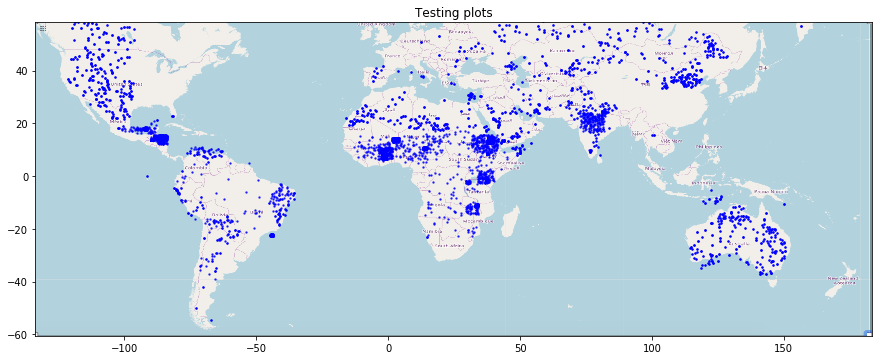

In [23]:
lats = np.array(lats)
longs = np.array(longs)
area = plt.imread('../references/world_plots.png')

fig, ax = plt.subplots(figsize = (15,21))
ax.scatter(longs, lats, zorder=1, alpha= 0.7, c='b', s=2)
ax.set_title('Testing plots')
ax.set_xlim(region[0],region[1])
ax.set_ylim(region[2],region[3])
ax.imshow(area, zorder=0, extent = region, aspect= 'equal')
#plt.savefig('../references/{}-plots.png'.format("test"), dpi = 300)